In [63]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
import lightgbm as lgb
import ast
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from scipy import stats
import joblib
import HappyML.preprocessor as pp
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler
import shap
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

# 添加以下函數來計算 RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [15]:
route_prefix = f"/Users/USER/Downloads/Prediction/"

file_path = f"{route_prefix}Source csv/Multiple Sample.csv"

output_path = f"{route_prefix}Temporary file/newTem.csv"

In [57]:
# 編碼對照
mapping_path = f"{route_prefix}Source csv/編碼對照.xlsx"
# 特徵檔
feature_path = f"{route_prefix}Models/feature_names.pkl"
# 模型檔
model_path = f"{route_prefix}Models/gbm_stage2.pkl"
# 違約率
default_path = f"{route_prefix}Source csv/違約率.csv"
# 字體位置
font_path = rf"{route_prefix}NotoSansTC-VariableFont_wght.ttf"
# 結果輸出
result_path = f"{route_prefix}Result csv/newPrediction.csv"
# 含shap預測
shap_predict_path = f"{route_prefix}Result csv/prediction_with_shap.csv"

In [17]:
customer_data = pd.read_csv(file_path, index_col=None)

In [18]:
customer_data = pd.read_csv(file_path, index_col = None)
# customer_data.dropna(subset=['AMFC2 評分分數'], inplace = True)
# customer_data.dropna(subset=['M0'], inplace = True)

customer_data['年資'] = pd.to_numeric(customer_data['年資'], errors='coerce')
customer_data['月薪'] = pd.to_numeric(customer_data['月薪'], errors='coerce')

years = customer_data['年資'].median()
salary = customer_data['月薪'].median()

fill_values = {
    '核准日': '無',
    '婚姻': '無資料',
    '教育程度': '無資料',
    '居住狀況': '無資料',
    '主要經營業務': '無資料',
    '年資': years,
    '月薪': salary
}

customer_data = customer_data.fillna(value=fill_values)

customer_data = customer_data.fillna('無資料')


# 計算月薪和年資的中位數
monthly_salary_median = customer_data['月薪'].median()
years_of_service_median = customer_data['年資'].median()

# 將超過100萬的月薪替換為中位數
customer_data['月薪＿原資料'] = np.where(customer_data['月薪'] > 100, monthly_salary_median, customer_data['月薪'])

# 將超過70年的年資替換為中位數
customer_data['年資＿原資料'] = np.where(customer_data['年資'] > 70, years_of_service_median, customer_data['年資'])

# 正規化處理
scaler_minmax = MinMaxScaler()
customer_data[['月薪', '年資']] = scaler_minmax.fit_transform(customer_data[['月薪＿原資料', '年資＿原資料']])

# 讀取映射表
mapping_df = pd.read_excel(mapping_path, sheet_name=None)

# 創建一個字典來存儲每個列的原始值到編碼值的映射
column_mappings = {}

# 讀取每個工作表並創建映射
for sheet_name, df in mapping_df.items():
    column_mappings[sheet_name] = dict(zip(df['Original'], df['Encoded']))

# 對 customer_data 進行編碼
columns_to_encode = ['專案名稱', '業務人員', '主要經營業務', '產品別']

for column in columns_to_encode:
    if column in column_mappings:
        # 使用映射來編碼數據
        customer_data[column] = customer_data[column].map(column_mappings[column])

        # 處理可能的新值（不在映射表中的值）
        missing_values = customer_data[column].isna()
        if missing_values.any():
            # 為新值分配新的編碼
            new_values = customer_data.loc[missing_values, column].unique()
            max_encoded = max(column_mappings[column].values()) if column_mappings[column] else 0
            for i, value in enumerate(new_values, start=max_encoded+1):
                column_mappings[column][value] = i
            customer_data.loc[missing_values, column] = customer_data.loc[missing_values, column].map(column_mappings[column])
    else:
        print(f"警告：'{column}' 的映射資料不存在。")

In [19]:
def extract_taiwan_date(taiwan_date):
    try:
        if isinstance(taiwan_date, str) and '/' in taiwan_date:
            year, month, day = map(int, taiwan_date.split('/'))
            # 轉換民國年為西元年
            year += 1911
            return year, month, day
        return None, None, None
    except (ValueError, AttributeError):
        return None, None, None

# 提取進件日期的年月日
customer_data[['進件（年）', '進件（月）', '進件（日）']] = pd.DataFrame(
    customer_data['進件日期'].apply(extract_taiwan_date).tolist(),
    index=customer_data.index
)

# 提取出生日期的年月日
customer_data[['出生（年）', '出生（月）', '出生（日）']] = pd.DataFrame(
    customer_data['出生日期'].apply(extract_taiwan_date).tolist(),
    index=customer_data.index
)

# 計算各欄位的中位數
進件年_median = customer_data['進件（年）'].median()
進件月_median = customer_data['進件（月）'].median()
進件日_median = customer_data['進件（日）'].median()

出生年_median = customer_data['出生（年）'].median()
出生月_median = customer_data['出生（月）'].median()
出生日_median = customer_data['出生（日）'].median()

# 填補空值
customer_data['進件（年）'] = customer_data['進件（年）'].fillna(進件年_median)
customer_data['進件（月）'] = customer_data['進件（月）'].fillna(進件月_median)
customer_data['進件（日）'] = customer_data['進件（日）'].fillna(進件日_median)

customer_data['出生（年）'] = customer_data['出生（年）'].fillna(出生年_median)
customer_data['出生（月）'] = customer_data['出生（月）'].fillna(出生月_median)
customer_data['出生（日）'] = customer_data['出生（日）'].fillna(出生日_median)

# 將數值轉換為整數
date_columns = ['進件（年）', '進件（月）', '進件（日）', '出生（年）', '出生（月）', '出生（日）']
for col in date_columns:
    customer_data[col] = customer_data[col].astype(int)

# 可以刪除原始日期欄位，因為已經不需要了
customer_data.drop(['進件日期', '出生日期'], axis=1, inplace=True)

In [20]:
marital_status_mapping = {'未婚': 2, '已婚': 4, '離婚': 1, '同居': 3, '無資料': 0}
education_level_mapping = {
    '小學': 1, '國中': 2, '高中/職': 3, '高中': 4, '專科': 5, '大學': 7,
    '專科/大學': 6, '研究所以上': 9, '無資料': 0, '其他': 0, '博士': 10, '碩士': 8
}
living_status_mapping = {'租屋': 2, '配偶': 4, '親屬': 3, '自有':5 , '宿舍': 1, '無資料': 0}
existing_customer_mapping = {'是': 0, '否': 1}


customer_data['婚姻'] = customer_data['婚姻'].map(marital_status_mapping)
customer_data['教育程度'] = customer_data['教育程度'].map(education_level_mapping)
customer_data['居住狀況'] = customer_data['居住狀況'].map(living_status_mapping)
customer_data['既有客戶'] = customer_data['既有客戶'].map(existing_customer_mapping)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# 移除 num_words 參數
tokenizer = Tokenizer()

# 處理申請人姓名
customer_name = customer_data['申請人姓名'].astype(str)
tokenizer.fit_on_texts(customer_name)
sequences = tokenizer.texts_to_sequences(customer_name)
customer_data['申請人姓名'] = sequences

# 處理廠商名稱
firm_name = customer_data['廠商名稱'].astype(str)
tokenizer.fit_on_texts(firm_name)
sequences = tokenizer.texts_to_sequences(firm_name)
customer_data['廠商名稱'] = sequences

def newScore(predicted_value, current, m0, m1_1, m1_2, m2, m3, m4, m5, m6):
    base_penalty = -0.01  # 統一的基礎負面調整值
    k = 0.02  # 增加 k 值以增強非線性效果
    adjustment = (base_penalty * current * -1 +
                  base_penalty * m0 * np.exp(k * 3.5) +  # 0-7天的中位數是3.5天
                  base_penalty * m1_1 * np.exp(k * 11) +  # 7-15天的中位數是11天
                  base_penalty * m1_2 * np.exp(k * 22.5) +  # 15-30天的中位數是22.5天
                  base_penalty * m2 * np.exp(k * 45.5) +  # 31-60天的中位數是45.5天
                  base_penalty * m3 * np.exp(k * 75.5) +  # 61-90天的中位數是75.5天
                  base_penalty * m4 * np.exp(k * 105.5) +  # 91-120天的中位數是105.5天
                  base_penalty * m5 * np.exp(k * 135.5) +  # 121-150天的中位數是135.5天
                  base_penalty * m6 * np.exp(k * 151))  # 更新 M6 为 151 天以上
    adjusted_score = predicted_value * (1 + adjustment)
    # 確保分數至少為0
    adjusted_score = max(0, adjusted_score)
    return adjusted_score

def apply_new_score(row):
    return newScore(
        predicted_value=row['AMFC2 評分分數'],
        current=row['Current'],
        m0=row['M0'],
        m1_1=row['M1-1'],
        m1_2=row['M1-2'],
        m2=row['M2'],
        m3=row['M3'],
        m4=row['M4'],
        m5=row['M5'],
        m6=row['M6']
    )

# 應用函數並添加新列
# customer_data['調整後原始分數'] = customer_data.apply(apply_new_score, axis=1)

# 定義想要的欄位順序
desired_columns = [
    '流水號', '進件（年）', '進件（月）', '進件（日）', '專案名稱',
    '申請人姓名', '身份證字號', '既有客戶', '業務人員', '廠商名稱', '產品別',
    '期數', '出生（年）', '出生（月）', '出生（日）', '婚姻', '教育程度',
    '居住郵遞區號', '居住狀況', '主要經營業務', '年資＿原資料', '月薪＿原資料',
    '月薪', '年資'
]

# 選擇並重新排序欄位
customer_data = customer_data[desired_columns]

customer_data.to_csv(output_path)

In [21]:
pd.set_option('display.max_columns', None)
dataset = pd.read_csv(output_path)
print(len(dataset))# dataset = customer_data
low_memory=False

2000


In [23]:
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return val

def extract_features_from_id(id_code):
    # 確保id_code是字符串
    id_code = str(id_code)

    # 確保id_code至少有兩個字符
    if len(id_code) < 2:
        return None, None

    # 提取第一個字符並轉換為ASCII值
    first_char_ascii = id_code[0].upper()

    # 提取第一個數字
    first_digit = next((int(char) for char in id_code[1:] if char.isdigit()), None)

    return first_char_ascii, first_digit

id_columns = ["身份證字號"]

for column in id_columns:
    new_columns = [f"{column}_char_ascii", f"{column}_first_digit"]
    extracted_features = dataset[column].apply(lambda x: extract_features_from_id(safe_literal_eval(x)))
    vector_df = pd.DataFrame(extracted_features.tolist(), columns=new_columns)
    dataset = pd.concat([dataset, vector_df], axis=1)
    dataset.drop(columns=[column], inplace=True)

In [24]:
dataset.columns


Index(['Unnamed: 0', '流水號', '進件（年）', '進件（月）', '進件（日）', '專案名稱', '申請人姓名', '既有客戶',
       '業務人員', '廠商名稱', '產品別', '期數', '出生（年）', '出生（月）', '出生（日）', '婚姻', '教育程度',
       '居住郵遞區號', '居住狀況', '主要經營業務', '年資＿原資料', '月薪＿原資料', '月薪', '年資',
       '身份證字號_char_ascii', '身份證字號_first_digit'],
      dtype='object')

In [25]:
def clean_object_columns_to_int64(df, columns_to_clean):
    def clean_column(x):
        if isinstance(x, (int, np.integer)):
            return x
        elif isinstance(x, str):
            try:
                return int(float(x))
            except ValueError:
                return x  # 暫時保留原始值，稍後會進行編碼
        elif isinstance(x, (list, dict)):
            return str(x)  # 將列表或字典轉換為字符串
        else:
            return x

    encoders = {}

    for column in columns_to_clean:
        if column in df.columns:
            df[column] = df[column].apply(clean_column)

            if df[column].dtype != 'int64':
                # 使用 LabelEncoder 將非整數值編碼為整數
                encoder = LabelEncoder()
                df[column] = encoder.fit_transform(df[column].astype(str))
                encoders[column] = encoder

            df[column] = df[column].astype('int64')

    return df, encoders

# 需要清理的列
columns_to_clean = ['申請人姓名', '廠商名稱']
dataset, _ = clean_object_columns_to_int64(dataset, columns_to_clean)

In [26]:
dataset.columns

Index(['Unnamed: 0', '流水號', '進件（年）', '進件（月）', '進件（日）', '專案名稱', '申請人姓名', '既有客戶',
       '業務人員', '廠商名稱', '產品別', '期數', '出生（年）', '出生（月）', '出生（日）', '婚姻', '教育程度',
       '居住郵遞區號', '居住狀況', '主要經營業務', '年資＿原資料', '月薪＿原資料', '月薪', '年資',
       '身份證字號_char_ascii', '身份證字號_first_digit'],
      dtype='object')

In [44]:
columns_to_select = ['進件（年）', '進件（月）',
                    '進件（日）', '專案名稱', '申請人姓名',
                    '既有客戶', '業務人員', '廠商名稱',
                    '產品別', '期數', '出生（年）',
                    '出生（月）', '出生（日）', '婚姻',
                    '教育程度', '居住郵遞區號', '居住狀況',
                    '主要經營業務', '月薪', '年資',
                    '身份證字號_char_ascii', '身份證字號_first_digit']

column_indices = [dataset.columns.get_loc(col) for col in columns_to_select]

In [45]:
dataset['居住郵遞區號'] = pd.to_numeric(dataset['居住郵遞區號'], errors='coerce')
dataset['居住郵遞區號'] = dataset['居住郵遞區號'].fillna(0).astype(int)

In [46]:
X = dataset.iloc[:, column_indices]

columns_to_one_hot = ['主要經營業務', '身份證字號_char_ascii','身份證字號_first_digit', '既有客戶', '業務人員', '專案名稱', '產品別', '居住狀況', '婚姻']

column_indices_one_hot = [X.columns.get_loc(col) for col in columns_to_one_hot]

X = pp.onehot_encoder(X, columns=column_indices_one_hot , remove_trap=True)

# Y = dataset['調整後原始分數']

nan_count_per_column = X.isnull().sum()

In [47]:
# 按照訓練時的特徵順序排列
feature_names = joblib.load(feature_path)
for feature in feature_names:
    if feature not in X.columns:
        X[feature] = False

X = X[feature_names]

In [48]:
X = X.fillna(False)

X.shape

(2000, 160)

In [49]:
model = joblib.load(model_path)
pd.options.mode.chained_assignment = None  # 關閉警告訊息

In [51]:
y_pred = model.predict(X)

In [52]:
print(y_pred)

[363.03259742 381.44143435 347.12615187 ... 377.37190893 377.37190893
 370.16844251]


In [53]:
default_rate = pd.read_csv(default_path)
default_rate.head()

def get_default_rate(y_pred):
    
    def interpolate_default_rate(score):
        score = round(score)
        lower_bin = default_rate[default_rate['分數區間'] <= score]['分數區間'].max()
        upper_bin = default_rate[default_rate['分數區間'] > score]['分數區間'].min()
        
        if pd.isna(lower_bin):
            return default_rate[default_rate['分數區間'] == upper_bin]['違約率'].iloc[0]
        if pd.isna(upper_bin):
            return default_rate[default_rate['分數區間'] == lower_bin]['違約率'].iloc[0]
            
        lower_rate = float(default_rate[default_rate['分數區間'] == lower_bin]['違約率'].iloc[0].replace('%', ''))  # Remove '%' and convert to float
        upper_rate = float(default_rate[default_rate['分數區間'] == upper_bin]['違約率'].iloc[0].replace('%', ''))  # Remove '%' and convert to float
        
        weight = (score - lower_bin) / (upper_bin - lower_bin)
        interpolated_rate = lower_rate + (upper_rate - lower_rate) * weight
        result = round(interpolated_rate, 2)
        return f'{result}%'
    
    return np.array([interpolate_default_rate(score) for score in y_pred])

In [58]:
result_df = pd.DataFrame({
    '流水號': dataset.loc[X.index, '流水號'].reset_index(drop=True),
    '預測分數': y_pred,
    '參考違約率': get_default_rate(y_pred)
})

In [59]:
try:
    result_df.to_csv(result_path, index=False)
except Exception as e:
    print(f"發生錯誤: {e}")

if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams['axes.unicode_minus'] = False
else:
    print(f"Font file not found: {font_path}")

In [67]:
def get_top_shap_features(explainer, X_df, index):
    shap_values = explainer.shap_values(X_df.iloc[[index]])
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    feature_importance = pd.DataFrame({
        'feature': X_df.columns,
        'value': X_df.iloc[index].values,
        'shap_value': shap_values[0],
        'abs_shap_value': abs(shap_values[0])
    })

    feature_importance = feature_importance.sort_values('abs_shap_value', ascending=False)

    return (feature_importance['feature'].tolist(),
            feature_importance['value'].tolist(),
            feature_importance['shap_value'].tolist())

In [69]:
def plot_top_5_shap(model, X_single):
    if isinstance(X_single, pd.Series):
        X_single = X_single.to_frame().T

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_single)

    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    shap_df = pd.DataFrame({
        '特徵名稱': X_single.columns,
        'SHAP值': shap_values[0],
        '特徵值': X_single.iloc[0].values,
        '影響程度': abs(shap_values[0])
    })

    shap_df = shap_df.sort_values('影響程度', ascending=False).head(5)

    plt.figure(figsize=(10, 6))
    bars = plt.barh(range(len(shap_df)), shap_df['SHAP值'])

    colors = ['red' if x > 0 else 'blue' for x in shap_df['SHAP值']]
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    for i, (feature, value, shap_value) in enumerate(zip(shap_df['特徵名稱'],
                                                        shap_df['特徵值'],
                                                        shap_df['SHAP值'])):
        plt.text(-0.1, i, f'{feature}: {value:.2f}',
                ha='right', va='center', fontsize=10)

        x_pos = shap_value + (0.1 if shap_value >= 0 else -0.1)
        ha_align = 'left' if shap_value >= 0 else 'right'
        plt.text(x_pos, i, f'{shap_value:.3f}',
                ha=ha_align, va='center', fontsize=10)

    plt.title('前5名重要特徵對信用評分的影響程度')
    plt.xlabel('SHAP值 (紅色=正向影響, 藍色=負向影響)')
    plt.ylabel('特徵名稱')
    plt.grid(True, alpha=0.3)
    plt.gca().invert_yaxis()
    plt.tight_layout()

In [70]:
def analyze_single_record(model, X_df, dataset, y_pred):
    explainer = shap.TreeExplainer(model)

    result_df = pd.DataFrame({
        '流水號': dataset.loc[X_df.index, '流水號'].reset_index(drop=True),
        '預測分數': y_pred,
        '參考違約率': get_default_rate(y_pred)
    })

    for i in range(len(X_df)):
        feature_names, feature_values, shap_values = get_top_shap_features(explainer, X_df, i)

        for j in range(5):
            result_df.loc[i, f'重要特徵{j+1}_名稱'] = feature_names[j]
            result_df.loc[i, f'重要特徵{j+1}_數值'] = feature_values[j]
            result_df.loc[i, f'重要特徵{j+1}_SHAP值'] = round(shap_values[j], 2)

    plot_top_5_shap(model, X_df)

    return result_df

In [71]:
def analyze_multiple_records(model, X_df, dataset, y_pred):
    explainer = shap.TreeExplainer(model)

    result_df = pd.DataFrame({
        '流水號': dataset.loc[X_df.index, '流水號'].reset_index(drop=True),
        '預測分數': y_pred,
        '參考違約率': get_default_rate(y_pred)
    })

    for i in range(len(X_df)):
        feature_names, feature_values, shap_values = get_top_shap_features(explainer, X_df, i)

        for j in range(5):
            result_df.loc[i, f'重要特徵{j+1}_名稱'] = feature_names[j]
            result_df.loc[i, f'重要特徵{j+1}_數值'] = feature_values[j]
            result_df.loc[i, f'重要特徵{j+1}_SHAP值'] = round(shap_values[j], 2)

    # 獲取SHAP值
    shap_values = explainer.shap_values(X_df)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    # 計算特徵重要性
    feature_importance = pd.DataFrame({
        '特徵名稱': X_df.columns,
        'SHAP值_平均': np.mean(abs(shap_values), axis=0)
    }).sort_values('SHAP值_平均', ascending=False)

    top_10_features = feature_importance.head(10)['特徵名稱'].tolist()

    # 創建圖形和軸
    fig, ax = plt.subplots(figsize=(12, 8))

    # 準備數據並進行標準化
    plot_data = pd.DataFrame()
    for i, feature in enumerate(top_10_features):
        # 獲取特徵值並處理布林值
        feature_vals = X_df[feature].values

        # 檢查是否為布林值或含有布林值的序列
        if pd.api.types.is_bool_dtype(feature_vals) or pd.api.types.is_object_dtype(feature_vals):
            feature_vals = np.where(feature_vals == True, 1, 0)

        # 確保特徵值為數值型態
        feature_vals = feature_vals.astype(float)

        shap_vals = shap_values[:, X_df.columns.get_loc(feature)]

        # 如果所有值都相同，標準化後的值設為0
        if np.std(feature_vals) == 0:
            feature_vals_std = np.zeros_like(feature_vals)
        else:
            # 標準化特徵值
            feature_vals_std = (feature_vals - np.mean(feature_vals)) / np.std(feature_vals)

        temp_df = pd.DataFrame({
            '特徵值': feature_vals,
            '標準化特徵值': feature_vals_std,
            'SHAP值': shap_vals,
            '特徵名稱': feature
        })
        plot_data = pd.concat([plot_data, temp_df])

    # 創建自定義顏色映射
    from matplotlib.colors import LinearSegmentedColormap, ListedColormap

    # 定義顏色列表：從深藍到淺紫到深紅
    colors = [
        '#2D65FF',  # 深藍
        '#EC8BFF',
        '#FF2D2D'   # 深紅
    ]

    # 創建新的顏色映射
    custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

    # 設定配色方案和樣式
    colors = {
        'violin_color': '#F0F0F0',  # 淺灰色作為violin plot的底色
        'colormap': custom_cmap
    }

    # 繪製violin plot
    sns.violinplot(data=plot_data,
                  x='SHAP值',
                  y='特徵名稱',
                  order=top_10_features,
                  cut=0,
                  scale='width',
                  inner='quartile',
                  color=colors['violin_color'],
                  alpha=0.9,
                  ax=ax)

    # 在violin plot上疊加散點圖
    for feature in top_10_features:
        feature_data = plot_data[plot_data['特徵名稱'] == feature]

        # 使用標準化後的值來決定顏色
        norm = plt.Normalize(-1, 1)  # 調整範圍以獲得更好的顏色分布

        # 添加散點圖
        scatter = ax.scatter(feature_data['SHAP值'],
                           [top_10_features.index(feature)] * len(feature_data),
                           c=feature_data['標準化特徵值'],
                           cmap=colors['colormap'],
                           norm=norm,
                           alpha=0.7,
                           s=40)

    # 添加顏色條
    sm = plt.cm.ScalarMappable(cmap=colors['colormap'], norm=norm)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('標準化特徵值', fontsize=10)

    # 設置圖表樣式
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.set_title('SHAP Summary Plot (標準化特徵值)', pad=20, fontsize=12)
    ax.set_xlabel('SHAP值', fontsize=10)
    ax.set_ylabel('特徵名稱', fontsize=10)
    ax.grid(True, axis='x', alpha=0.2, linestyle='--')
    ax.tick_params(axis='both', labelsize=9)

    # 設置背景顏色為淺灰色
    ax.set_facecolor('#E7E7E7')

    plt.tight_layout()

    return result_df

In [72]:
def analyze_shap(model, X_df, dataset, y_pred, output_path: str):
    if len(X_df) == 1:
        result = analyze_single_record(model, X_df, dataset, y_pred)
    else:
        result = analyze_multiple_records(model, X_df, dataset, y_pred)

    result.to_csv(output_path, index=False)
    plt.show()
    return result

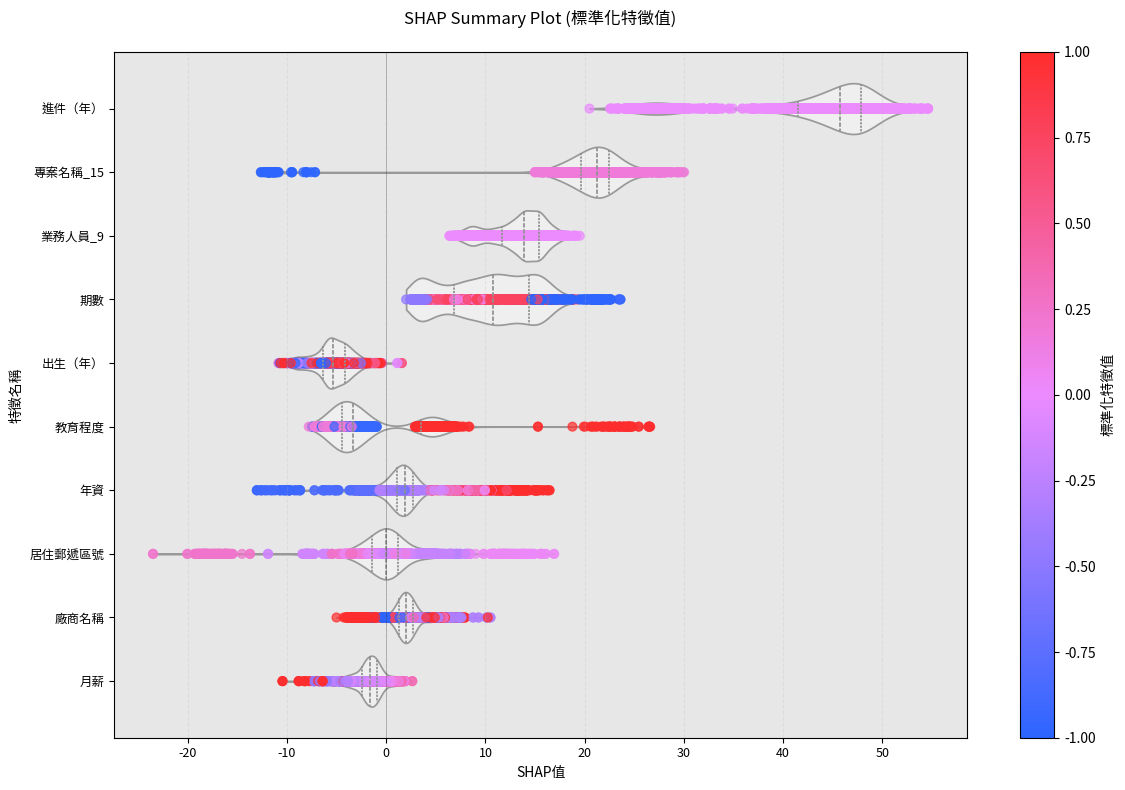

In [73]:
result = analyze_shap(model, X, dataset, y_pred, shap_predict_path)